## Importando as bibliotecas utilizadas

In [95]:
%matplotlib inline
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from scipy.spatial import distance as dist
from imutils.perspective import four_point_transform
from imutils import contours
import imutils

##Lembrar de verificar quais libs nao estao sendo utilizada

## Transformando a imagem de exemplo em preto e branco

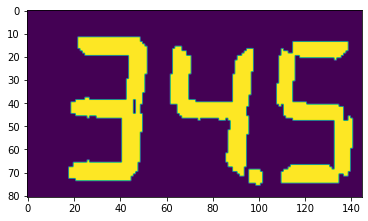

In [120]:
DIGITS_LOOKUP = {
    (1, 1, 1, 0, 1, 1, 1): 0,
    (0, 0, 1, 0, 0, 1, 0): 1,
    (1, 0, 1, 1, 1, 1, 0): 2,
    (1, 0, 1, 1, 0, 1, 1): 3,
    (0, 1, 1, 1, 0, 1, 0): 4,
    (1, 1, 0, 1, 0, 1, 1): 5,
    (1, 1, 0, 1, 1, 1, 1): 6,
    (1, 0, 1, 0, 0, 1, 0): 7,
    (1, 1, 1, 1, 1, 1, 1): 8,
    (1, 1, 1, 1, 0, 1, 1): 9,
    (1, 0, 1, 0, 0, 1, 1): -1
}
#print(DIGITS_LOOKUP[(1, 0, 1, 1, 1, 1, 0)])

imagem_exemplo = "ex.png"
image = cv2.imread(imagem_exemplo)

#Transformando a imagem em escala de cinza
gray_scale_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

#Revelando regioes mais escuras (ou seja, os digitos) do que a regiao claras (o fundo)
thresh = cv2.threshold(gray_scale_image, 0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]

#Limpando a imagem com operações morfologicas (Abertura e fechamento)

#Foram testados diferentes valores para o kernel (2....9), sendo o 4 o melhor resultado
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (1,4))

#Limpando a imagem com operações morfologicas (Abertura e fechamento)
thresh = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel)
closing = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, kernel)

plt.imshow(closing)

### Com os filtros aplicados a imagem, vamos trabalhar em cima dela

#### Primeiro, aplicamos o filtro de contorno, em seguida, armzenamos o contorno dos digitos.
#### Mostramos na tela os possiveis digitos contornados

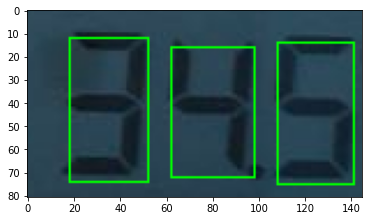

In [121]:
#Aplicando o filtro de contorno e encontrando-os
cnts = cv2.findContours(closing.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cnts = imutils.grab_contours(cnts)

#Lista para armazenar os contornos dos digitos
digitCnts = []

#Loops nos candidatos da area de digitos
for c in cnts:
    #Calcula a "caixa" de um possivel digito
    (x, y, w, h) = cv2.boundingRect(c)

    #if(w > 10 and (h >= 30 and h <=40)):
    if(w >= 10 and (h >= 3)):
        digitCnts.append(c)
        #Ultimo valor == espessura do retangulo
        #Pintando de verde (R, G, B)
        cv2.rectangle(image, (x,y), (x+w, y+h), (0, 255, 0), 1)

plt.imshow(image)


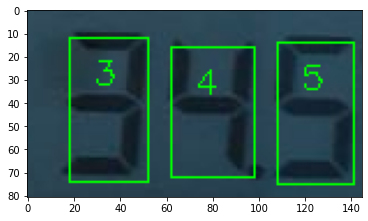

In [122]:
digitCnts = contours.sort_contours(digitCnts, method="left-to-right")[0]
digits = []

#############
#output = four_point_transform(image, displayCnt.reshape(4, 2))
#Loop em cada um dos digitos
output = image.copy()
for c in digitCnts:
    #Para cada uma das regioes, calculamos a caixa delimitadora e extraimos o digito ROI
    (x, y, w, h) = cv2.boundingRect(c)
    
    #Largura e altura aproximadas de cada segmento com base nas dimensoes do ROI
    roi = thresh[y:y + h, x:x + w]

    (roiH, roiW) = roi.shape
    (dW, dH) = (int(roiW * 0.25), int(roiH * 0.15))
    dHC = int(roiH * 0.05)
    
    #Lista de (x, y) coordenadas que correspondem aos sete segmentos
    segments = [
        ((0, 0), (w, dH)),                           # top
        ((0, 0), (dW, h // 2)),                      # top-left
        ((w - dW, 0), (w, h // 2)),                  # top-right
        ((0, (h // 2) - dHC) , (w, (h // 2) + dHC)), # center
        ((0, h // 2), (dW, h)),	                     # bottom-left
        ((w - dW, h // 2), (w, h)),                  # bottom-right
        ((0, h - dH), (w, h))                        # bottom
    ]
    
    #Lista que nforma se determinado segmento esta ligado. Valor 0 == segmento desligado
    #[0, 0, 0, 0, 0, 0, 0]
    on_list = [0] * len(segments)
    
    #Loop sobre os segmentos
    for (i, ((xA, yA), (xB, yB))) in enumerate(segments):
        #Extraindo o ROI do segmento
        segROI = roi[yA:yB, xA:xB]
        #Numero de pixels do segmento q estao "ligados"
        total = cv2.countNonZero(segROI)
        area = (xB - xA) * (yB - yA)
        
        
        #Se a proporcao de pixels diferentes de 0 para a area do segmento 
        #for maior que 50% => O segmento estao ligado
        
        if(total / float(area)) > 0.5:
            on_list[i] = 1
    
    #Obtendo o digito em si
    #print(tuple(on))
    digit = DIGITS_LOOKUP[tuple(on_list)]
    digits.append(digit)
    
    #Desenhando uma caixa em torno do digito e exibindo qual digito ele eh
    #cv2.rectangle(image.copy(), (x, y), (x + w, y + h), (0, 255, 0), 1)
    #input()
    cv2.putText(output, str(digit), (x+10,y+20), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 1)
plt.imshow(output)
